In [ ]:
#Brain MRI images classification 
#The model was trained on 13 classes of brain diseases 

#Credits:
#Ajmain, Moshfiqur Rahman; Khatun, Mst. Farhana; khushbu, sharun akter (2024), “Benchmark Diagnostic MRI and Medical Imaging Dataset ”, Mendeley Data, V1, doi: 10.17632/d73rs38yk6.1
#https://data.mendeley.com/datasets/d73rs38yk6/1

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
#/kaggle/input/d/omerii/brainmri/Medical Imaging Dataset/

In [5]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns






DATA_DIR = "/kaggle/input/d/omerii/brainmri/Medical Imaging Dataset/"
print(f"DATA_DIR set to: {DATA_DIR}")
BATCH_SIZE = 16
IMG_SIZE = 224
NUM_EPOCHS = 40
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


DATA_DIR set to: /kaggle/input/d/omerii/brainmri/Medical Imaging Dataset/


In [6]:
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [7]:
full_dataset = datasets.ImageFolder(DATA_DIR, transform=transform_train)
num_classes = len(full_dataset.classes)
print(f"Detected {num_classes} classes: {full_dataset.classes}")


targets = np.array([label for _, label in full_dataset.samples])


splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(splitter.split(np.zeros(len(targets)), targets))


temp_targets = targets[temp_idx]
splitter_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(splitter_val_test.split(np.zeros(len(temp_targets)), temp_targets))


val_idx = temp_idx[val_idx]
test_idx = temp_idx[test_idx]


train_data = Subset(full_dataset, train_idx)
val_data = Subset(full_dataset, val_idx)
test_data = Subset(full_dataset, test_idx)


train_data.dataset.transform = transform_train
val_data.dataset.transform = transform_val_test
test_data.dataset.transform = transform_val_test


train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

Detected 14 classes: ['Acute Cerebellitis in HIV', 'Balloon Cell Cortical Dysplasia', 'Congenital Toxoplasmosis', 'Hepatocellular Carcinoma (HCC) and Dysplastic Nodules with Cirrhosis', 'Japanese B Encephalitis or Epstein-Barr Encephalitis', 'Moyamoya Disease with Intraventricular Hemorrhage', 'Neurofibromatosis Type 1 (NF1) with Optic Glioma and Intracranial Extension', 'Optic Glioma', 'Osmotic Demyelination Syndrome', 'Perisylvian Syndrome', 'Plexiform Neurofibroma with Sphenoid Wing Absence', 'Rasmussens Encephalitis', 'Typical Adrenoleukodystrophy', 'Walker-Warburg Syndrome']
Train: 9245, Val: 1981, Test: 1982


In [8]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

custom_model = CustomCNN(num_classes).to(DEVICE)

In [9]:
def train_model(model, train_loader, val_loader, num_epochs=NUM_EPOCHS):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,     
    patience=3,     
    verbose=True)


    
    best_val_acc = 0
    train_accs, val_accs = [], []
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):

        model.train()
        running_loss, correct, total = 0, 0, 0
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

       
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        scheduler.step(val_loss)
        
        print(f"\nEpoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()

    model.load_state_dict(best_model)
    return model, train_losses, val_losses, train_accs, val_accs

In [10]:
custom_model, train_losses, val_losses, train_accs, val_accs = train_model(custom_model, train_loader, val_loader)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/40 [Val]: 100%|██████████| 124/124 [00:15<00:00,  7.78it/s]



Epoch [1/40] Train Loss: 2.1648 | Train Acc: 0.2992 | Val Loss: 1.5931 | Val Acc: 0.4705


Epoch 2/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 12.74it/s]



Epoch [2/40] Train Loss: 1.6712 | Train Acc: 0.4446 | Val Loss: 1.2803 | Val Acc: 0.5987


Epoch 3/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 13.70it/s]



Epoch [3/40] Train Loss: 1.4247 | Train Acc: 0.5293 | Val Loss: 1.0462 | Val Acc: 0.6673


Epoch 4/40 [Val]: 100%|██████████| 124/124 [00:08<00:00, 13.86it/s]



Epoch [4/40] Train Loss: 1.1964 | Train Acc: 0.5971 | Val Loss: 0.9462 | Val Acc: 0.6966


Epoch 5/40 [Val]: 100%|██████████| 124/124 [00:11<00:00, 10.92it/s]



Epoch [5/40] Train Loss: 1.0694 | Train Acc: 0.6410 | Val Loss: 0.8408 | Val Acc: 0.7456


Epoch 6/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 12.56it/s]



Epoch [6/40] Train Loss: 0.9402 | Train Acc: 0.6796 | Val Loss: 0.8032 | Val Acc: 0.7431


Epoch 7/40 [Val]: 100%|██████████| 124/124 [00:10<00:00, 12.02it/s]



Epoch [7/40] Train Loss: 0.8551 | Train Acc: 0.7056 | Val Loss: 0.6967 | Val Acc: 0.7824


Epoch 8/40 [Val]: 100%|██████████| 124/124 [00:10<00:00, 11.79it/s]



Epoch [8/40] Train Loss: 0.7542 | Train Acc: 0.7457 | Val Loss: 0.6503 | Val Acc: 0.7885


Epoch 9/40 [Val]: 100%|██████████| 124/124 [00:10<00:00, 12.34it/s]



Epoch [9/40] Train Loss: 0.6914 | Train Acc: 0.7576 | Val Loss: 0.5323 | Val Acc: 0.8354


Epoch 10/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 12.86it/s]



Epoch [10/40] Train Loss: 0.6266 | Train Acc: 0.7837 | Val Loss: 0.5557 | Val Acc: 0.8208


Epoch 11/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 13.48it/s]



Epoch [11/40] Train Loss: 0.5638 | Train Acc: 0.8018 | Val Loss: 0.5750 | Val Acc: 0.8102


Epoch 12/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 13.52it/s]



Epoch [12/40] Train Loss: 0.5256 | Train Acc: 0.8147 | Val Loss: 0.5171 | Val Acc: 0.8385


Epoch 13/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 13.58it/s]



Epoch [13/40] Train Loss: 0.4804 | Train Acc: 0.8331 | Val Loss: 0.4851 | Val Acc: 0.8511


Epoch 14/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 13.47it/s]



Epoch [14/40] Train Loss: 0.4384 | Train Acc: 0.8468 | Val Loss: 0.4653 | Val Acc: 0.8587


Epoch 15/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 13.54it/s]



Epoch [15/40] Train Loss: 0.4109 | Train Acc: 0.8568 | Val Loss: 0.4231 | Val Acc: 0.8622


Epoch 16/40 [Val]: 100%|██████████| 124/124 [00:08<00:00, 14.01it/s]



Epoch [16/40] Train Loss: 0.3826 | Train Acc: 0.8665 | Val Loss: 0.3989 | Val Acc: 0.8733


Epoch 17/40 [Val]: 100%|██████████| 124/124 [00:08<00:00, 14.33it/s]



Epoch [17/40] Train Loss: 0.3628 | Train Acc: 0.8731 | Val Loss: 0.4107 | Val Acc: 0.8612


Epoch 18/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 13.76it/s]



Epoch [18/40] Train Loss: 0.3488 | Train Acc: 0.8782 | Val Loss: 0.3832 | Val Acc: 0.8763


Epoch 19/40 [Val]: 100%|██████████| 124/124 [00:08<00:00, 14.25it/s]



Epoch [19/40] Train Loss: 0.3181 | Train Acc: 0.8858 | Val Loss: 0.4811 | Val Acc: 0.8582


Epoch 20/40 [Val]: 100%|██████████| 124/124 [00:08<00:00, 14.32it/s]



Epoch [20/40] Train Loss: 0.3036 | Train Acc: 0.8926 | Val Loss: 0.4799 | Val Acc: 0.8465


Epoch 21/40 [Val]: 100%|██████████| 124/124 [00:08<00:00, 13.96it/s]



Epoch [21/40] Train Loss: 0.2765 | Train Acc: 0.9010 | Val Loss: 0.4080 | Val Acc: 0.8718


Epoch 22/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 13.01it/s]



Epoch [22/40] Train Loss: 0.2776 | Train Acc: 0.9007 | Val Loss: 0.4000 | Val Acc: 0.8763


Epoch 23/40 [Val]: 100%|██████████| 124/124 [00:08<00:00, 14.09it/s]



Epoch [23/40] Train Loss: 0.2018 | Train Acc: 0.9287 | Val Loss: 0.3390 | Val Acc: 0.8920


Epoch 24/40 [Val]: 100%|██████████| 124/124 [00:08<00:00, 14.21it/s]



Epoch [24/40] Train Loss: 0.1852 | Train Acc: 0.9339 | Val Loss: 0.3514 | Val Acc: 0.8940


Epoch 25/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 13.47it/s]



Epoch [25/40] Train Loss: 0.1737 | Train Acc: 0.9403 | Val Loss: 0.3541 | Val Acc: 0.8950


Epoch 26/40 [Val]: 100%|██████████| 124/124 [00:08<00:00, 14.06it/s]



Epoch [26/40] Train Loss: 0.1667 | Train Acc: 0.9415 | Val Loss: 0.3556 | Val Acc: 0.8889


Epoch 27/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 12.74it/s]



Epoch [27/40] Train Loss: 0.1675 | Train Acc: 0.9392 | Val Loss: 0.3478 | Val Acc: 0.8915


Epoch 28/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 12.44it/s]



Epoch [28/40] Train Loss: 0.1381 | Train Acc: 0.9510 | Val Loss: 0.3313 | Val Acc: 0.8980


Epoch 29/40 [Val]: 100%|██████████| 124/124 [00:10<00:00, 12.36it/s]



Epoch [29/40] Train Loss: 0.1356 | Train Acc: 0.9524 | Val Loss: 0.3411 | Val Acc: 0.9011


Epoch 30/40 [Val]: 100%|██████████| 124/124 [00:10<00:00, 12.03it/s]



Epoch [30/40] Train Loss: 0.1261 | Train Acc: 0.9569 | Val Loss: 0.3315 | Val Acc: 0.9041


Epoch 31/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 12.75it/s]



Epoch [31/40] Train Loss: 0.1251 | Train Acc: 0.9561 | Val Loss: 0.3329 | Val Acc: 0.8985


Epoch 32/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 12.59it/s]



Epoch [32/40] Train Loss: 0.1203 | Train Acc: 0.9588 | Val Loss: 0.3568 | Val Acc: 0.8920


Epoch 33/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 13.24it/s]



Epoch [33/40] Train Loss: 0.1054 | Train Acc: 0.9652 | Val Loss: 0.3442 | Val Acc: 0.9006


Epoch 34/40 [Val]: 100%|██████████| 124/124 [00:10<00:00, 12.39it/s]



Epoch [34/40] Train Loss: 0.1023 | Train Acc: 0.9657 | Val Loss: 0.3439 | Val Acc: 0.9031


Epoch 35/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 13.24it/s]



Epoch [35/40] Train Loss: 0.1029 | Train Acc: 0.9652 | Val Loss: 0.3379 | Val Acc: 0.9046


Epoch 36/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 13.57it/s]



Epoch [36/40] Train Loss: 0.1035 | Train Acc: 0.9655 | Val Loss: 0.3412 | Val Acc: 0.9016


Epoch 37/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 13.03it/s]



Epoch [37/40] Train Loss: 0.0882 | Train Acc: 0.9693 | Val Loss: 0.3463 | Val Acc: 0.9046


Epoch 38/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 13.61it/s]



Epoch [38/40] Train Loss: 0.0880 | Train Acc: 0.9709 | Val Loss: 0.3420 | Val Acc: 0.9031


Epoch 39/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 13.16it/s]



Epoch [39/40] Train Loss: 0.0900 | Train Acc: 0.9673 | Val Loss: 0.3371 | Val Acc: 0.9011


Epoch 40/40 [Val]: 100%|██████████| 124/124 [00:09<00:00, 12.91it/s]


Epoch [40/40] Train Loss: 0.0895 | Train Acc: 0.9691 | Val Loss: 0.3512 | Val Acc: 0.9011


In [11]:
resnet = models.resnet50(weights='IMAGENET1K_V1')
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet = resnet.to(DEVICE)
resnet, train_losses_resnet, val_losses_resnet, train_accs_resnet, val_accs_resnet = train_model(
    resnet, train_loader, val_loader)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 91.3MB/s]
Epoch 1/40 [Val]: 100%|██████████| 124/124 [00:13<00:00,  9.52it/s]



Epoch [1/40] Train Loss: 2.0627 | Train Acc: 0.4130 | Val Loss: 1.6012 | Val Acc: 0.6032


Epoch 2/40 [Val]: 100%|██████████| 124/124 [00:13<00:00,  9.34it/s]



Epoch [2/40] Train Loss: 1.5148 | Train Acc: 0.5942 | Val Loss: 1.2706 | Val Acc: 0.6653


Epoch 3/40 [Val]: 100%|██████████| 124/124 [00:13<00:00,  9.45it/s]



Epoch [3/40] Train Loss: 1.2756 | Train Acc: 0.6544 | Val Loss: 1.1011 | Val Acc: 0.6996


Epoch 4/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.54it/s]



Epoch [4/40] Train Loss: 1.1330 | Train Acc: 0.6876 | Val Loss: 0.9858 | Val Acc: 0.7340


Epoch 5/40 [Val]: 100%|██████████| 124/124 [00:13<00:00,  9.34it/s]



Epoch [5/40] Train Loss: 1.0343 | Train Acc: 0.7127 | Val Loss: 0.9055 | Val Acc: 0.7501


Epoch 6/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.59it/s]



Epoch [6/40] Train Loss: 0.9612 | Train Acc: 0.7280 | Val Loss: 0.8386 | Val Acc: 0.7749


Epoch 7/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.64it/s]



Epoch [7/40] Train Loss: 0.9072 | Train Acc: 0.7434 | Val Loss: 0.7984 | Val Acc: 0.7673


Epoch 8/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.62it/s]



Epoch [8/40] Train Loss: 0.8682 | Train Acc: 0.7582 | Val Loss: 0.7505 | Val Acc: 0.7966


Epoch 9/40 [Val]: 100%|██████████| 124/124 [00:13<00:00,  9.43it/s]



Epoch [9/40] Train Loss: 0.8256 | Train Acc: 0.7644 | Val Loss: 0.7135 | Val Acc: 0.7976


Epoch 10/40 [Val]: 100%|██████████| 124/124 [00:13<00:00,  9.49it/s]



Epoch [10/40] Train Loss: 0.7854 | Train Acc: 0.7776 | Val Loss: 0.6839 | Val Acc: 0.8077


Epoch 11/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.55it/s]



Epoch [11/40] Train Loss: 0.7654 | Train Acc: 0.7802 | Val Loss: 0.6740 | Val Acc: 0.7976


Epoch 12/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.64it/s]



Epoch [12/40] Train Loss: 0.7443 | Train Acc: 0.7867 | Val Loss: 0.6504 | Val Acc: 0.8082


Epoch 13/40 [Val]: 100%|██████████| 124/124 [00:13<00:00,  9.46it/s]



Epoch [13/40] Train Loss: 0.7009 | Train Acc: 0.8004 | Val Loss: 0.6287 | Val Acc: 0.8183


Epoch 14/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.66it/s]



Epoch [14/40] Train Loss: 0.6961 | Train Acc: 0.7953 | Val Loss: 0.6141 | Val Acc: 0.8228


Epoch 15/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.72it/s]



Epoch [15/40] Train Loss: 0.6679 | Train Acc: 0.8057 | Val Loss: 0.6057 | Val Acc: 0.8157


Epoch 16/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.74it/s]



Epoch [16/40] Train Loss: 0.6585 | Train Acc: 0.8080 | Val Loss: 0.5821 | Val Acc: 0.8349


Epoch 17/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.59it/s]



Epoch [17/40] Train Loss: 0.6436 | Train Acc: 0.8095 | Val Loss: 0.5615 | Val Acc: 0.8420


Epoch 18/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.68it/s]



Epoch [18/40] Train Loss: 0.6269 | Train Acc: 0.8174 | Val Loss: 0.5560 | Val Acc: 0.8344


Epoch 19/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.65it/s]



Epoch [19/40] Train Loss: 0.6246 | Train Acc: 0.8151 | Val Loss: 0.5411 | Val Acc: 0.8400


Epoch 20/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.63it/s]



Epoch [20/40] Train Loss: 0.6094 | Train Acc: 0.8142 | Val Loss: 0.5444 | Val Acc: 0.8299


Epoch 21/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.63it/s]



Epoch [21/40] Train Loss: 0.5961 | Train Acc: 0.8271 | Val Loss: 0.5211 | Val Acc: 0.8410


Epoch 22/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.65it/s]



Epoch [22/40] Train Loss: 0.5927 | Train Acc: 0.8217 | Val Loss: 0.5193 | Val Acc: 0.8450


Epoch 23/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.57it/s]



Epoch [23/40] Train Loss: 0.5756 | Train Acc: 0.8315 | Val Loss: 0.5091 | Val Acc: 0.8450


Epoch 24/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.65it/s]



Epoch [24/40] Train Loss: 0.5636 | Train Acc: 0.8342 | Val Loss: 0.5092 | Val Acc: 0.8481


Epoch 25/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.71it/s]



Epoch [25/40] Train Loss: 0.5591 | Train Acc: 0.8352 | Val Loss: 0.4924 | Val Acc: 0.8521


Epoch 26/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.60it/s]



Epoch [26/40] Train Loss: 0.5551 | Train Acc: 0.8345 | Val Loss: 0.4894 | Val Acc: 0.8556


Epoch 27/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.69it/s]



Epoch [27/40] Train Loss: 0.5389 | Train Acc: 0.8410 | Val Loss: 0.4846 | Val Acc: 0.8556


Epoch 28/40 [Val]: 100%|██████████| 124/124 [00:13<00:00,  9.49it/s]



Epoch [28/40] Train Loss: 0.5341 | Train Acc: 0.8420 | Val Loss: 0.4676 | Val Acc: 0.8587


Epoch 29/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.60it/s]



Epoch [29/40] Train Loss: 0.5270 | Train Acc: 0.8406 | Val Loss: 0.4662 | Val Acc: 0.8617


Epoch 30/40 [Val]: 100%|██████████| 124/124 [00:13<00:00,  9.29it/s]



Epoch [30/40] Train Loss: 0.5209 | Train Acc: 0.8441 | Val Loss: 0.4533 | Val Acc: 0.8688


Epoch 31/40 [Val]: 100%|██████████| 124/124 [00:13<00:00,  9.44it/s]



Epoch [31/40] Train Loss: 0.5099 | Train Acc: 0.8481 | Val Loss: 0.4535 | Val Acc: 0.8652


Epoch 32/40 [Val]: 100%|██████████| 124/124 [00:13<00:00,  9.45it/s]



Epoch [32/40] Train Loss: 0.5021 | Train Acc: 0.8527 | Val Loss: 0.4575 | Val Acc: 0.8647


Epoch 33/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.58it/s]



Epoch [33/40] Train Loss: 0.5055 | Train Acc: 0.8461 | Val Loss: 0.4467 | Val Acc: 0.8677


Epoch 34/40 [Val]: 100%|██████████| 124/124 [00:13<00:00,  9.52it/s]



Epoch [34/40] Train Loss: 0.4974 | Train Acc: 0.8499 | Val Loss: 0.4488 | Val Acc: 0.8667


Epoch 35/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.59it/s]



Epoch [35/40] Train Loss: 0.4948 | Train Acc: 0.8511 | Val Loss: 0.4387 | Val Acc: 0.8738


Epoch 36/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.66it/s]



Epoch [36/40] Train Loss: 0.4858 | Train Acc: 0.8544 | Val Loss: 0.4334 | Val Acc: 0.8733


Epoch 37/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.58it/s]



Epoch [37/40] Train Loss: 0.4791 | Train Acc: 0.8579 | Val Loss: 0.4247 | Val Acc: 0.8728


Epoch 38/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.68it/s]



Epoch [38/40] Train Loss: 0.4833 | Train Acc: 0.8528 | Val Loss: 0.4234 | Val Acc: 0.8723


Epoch 39/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.62it/s]



Epoch [39/40] Train Loss: 0.4710 | Train Acc: 0.8572 | Val Loss: 0.4247 | Val Acc: 0.8718


Epoch 40/40 [Val]: 100%|██████████| 124/124 [00:12<00:00,  9.67it/s]


Epoch [40/40] Train Loss: 0.4637 | Train Acc: 0.8623 | Val Loss: 0.4168 | Val Acc: 0.8768


In [12]:
def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Testing"):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = evaluate_model(custom_model, test_loader)
_, y_pred_resnet = evaluate_model(resnet, test_loader)



print(f"CUSTOM_CNN:\n{classification_report(y_true, y_pred, target_names=full_dataset.classes)}")
print(f"RESNET50:\n{classification_report(y_true, y_pred_resnet, target_names=full_dataset.classes)}")

Testing: 100%|██████████| 124/124 [00:13<00:00,  9.45it/s]

CUSTOM_CNN:
                                                                             precision    recall  f1-score   support

                                                  Acute Cerebellitis in HIV       0.90      0.86      0.88       147
                                            Balloon Cell Cortical Dysplasia       0.87      0.97      0.92       214
                                                   Congenital Toxoplasmosis       0.81      0.89      0.85        96
       Hepatocellular Carcinoma (HCC) and Dysplastic Nodules with Cirrhosis       0.99      0.97      0.98       149
                       Japanese B Encephalitis or Epstein-Barr Encephalitis       0.82      0.88      0.85       173
                          Moyamoya Disease with Intraventricular Hemorrhage       0.98      0.93      0.95       129
Neurofibromatosis Type 1 (NF1) with Optic Glioma and Intracranial Extension       0.87      0.87      0.87       141
                                                   

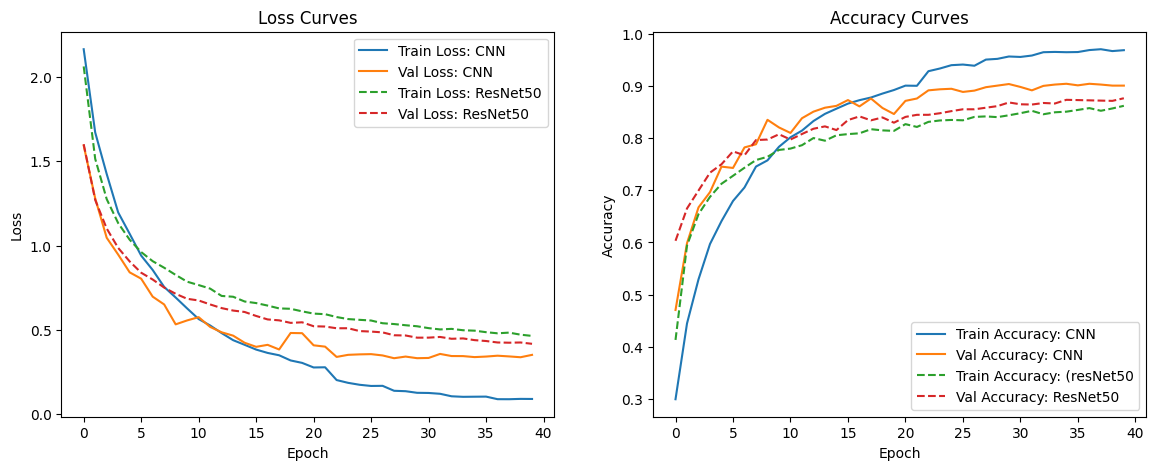

In [13]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss: CNN')
plt.plot(val_losses, label='Val Loss: CNN')
plt.plot(train_losses_resnet, label='Train Loss: ResNet50', linestyle='--')
plt.plot(val_losses_resnet, label='Val Loss: ResNet50', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()


plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy: CNN')
plt.plot(val_accs, label='Val Accuracy: CNN')
plt.plot(train_accs_resnet, label='Train Accuracy: (resNet50', linestyle='--')
plt.plot(val_accs_resnet, label='Val Accuracy: ResNet50', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.show()

In [ ]:
def sample_predictions(model, loader, classes, model_name="Model", n=6):
    
    model.eval()
    imgs, labels = next(iter(loader))
    imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

    with torch.no_grad():
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(15, 6))
    for i in range(n):
        plt.subplot(2, n//2, i + 1)
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        color = 'green' if preds[i] == labels[i] else 'red'
        plt.title(f"Pred: {classes[preds[i]]}\nTrue: {classes[labels[i]]}",
                  fontsize=9, color=color)
        plt.axis('off')

    plt.suptitle(f"Sample Predictions — {model_name}", fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

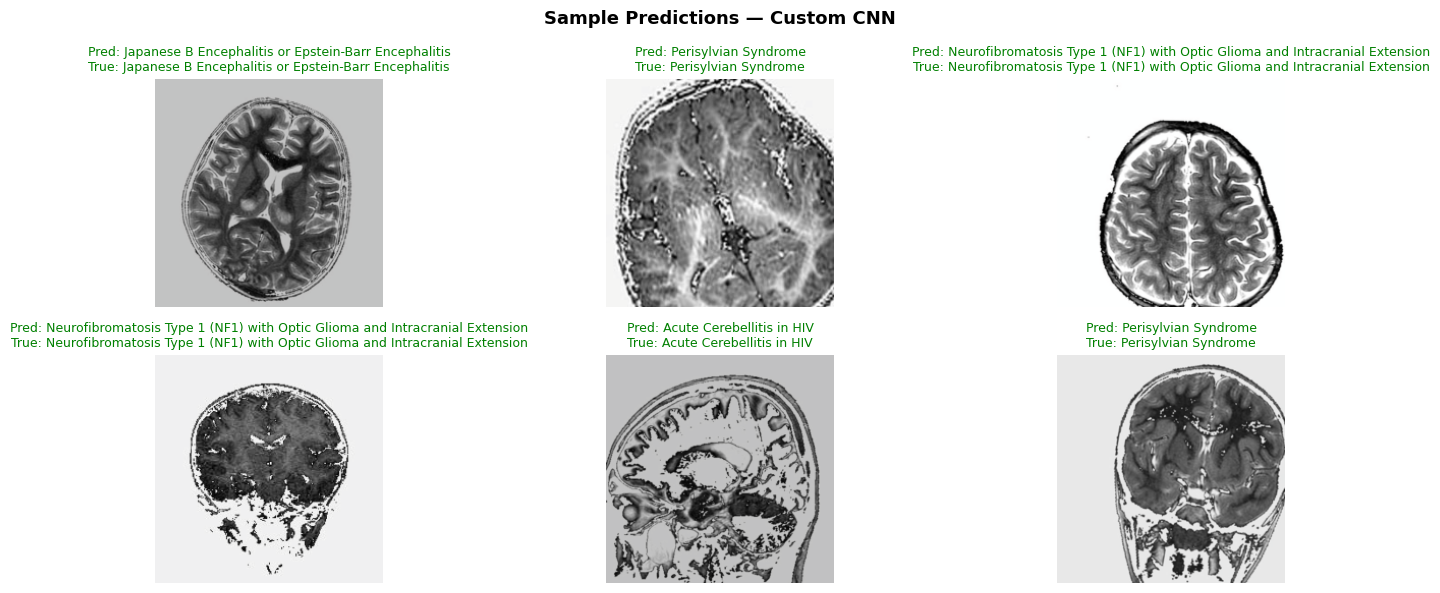

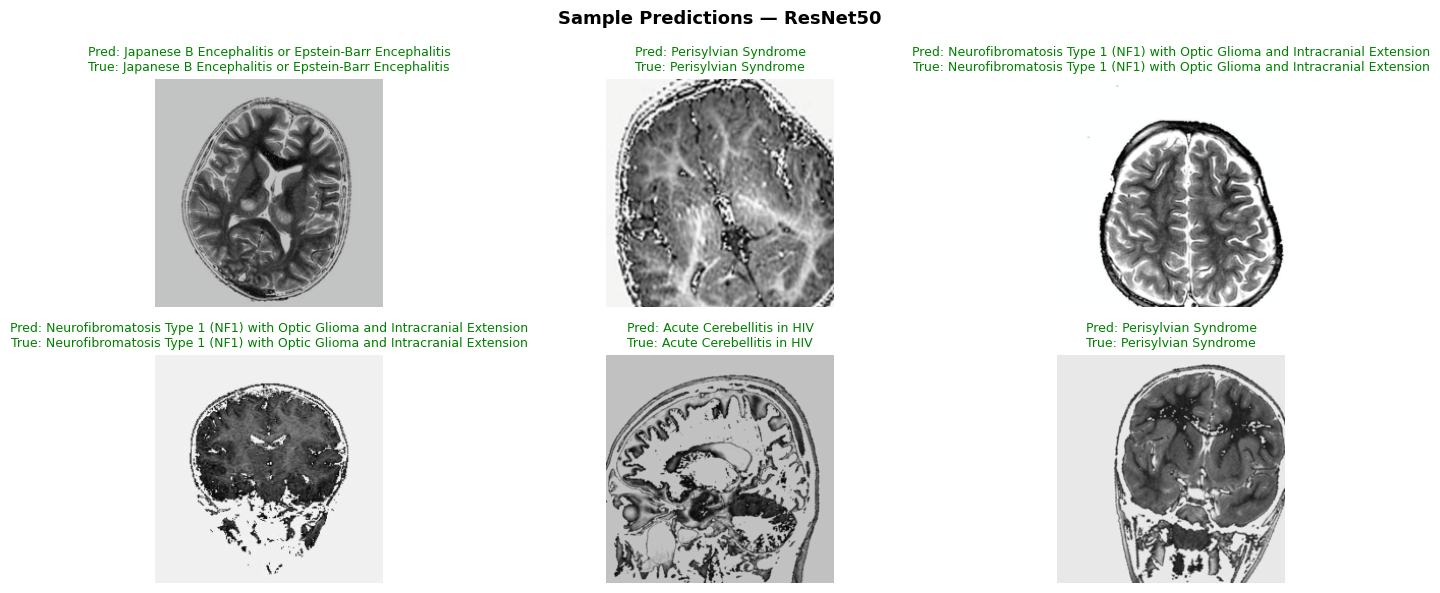

In [ ]:
sample_predictions(custom_model, test_loader, full_dataset.classes, model_name="Custom CNN", n=6)
sample_predictions(resnet, test_loader, full_dataset.classes, model_name="ResNet50", n=6)